# Robust Genomic Feature Selection Pipeline using an Ensemble of xAI Methods

## Imports

In [ ]:
!git clone https://github.com/vladislareon/Sparse_vector
!git clone https://github.com/vladislareon/z_dna

In [ ]:
!git clone https://github.com/vladislareon/Interpretation

In [ ]:
!pip install torch

In [1]:
# imports
import os
import numpy as np
import pandas as pd

from joblib import load
from tqdm.notebook import tqdm
from torch.utils import data

# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

import torch
from torch.utils import data

from Sparse_vector.sparse_vector import SparseVector
from graph_data_preparation import chrom_reader, get_train_test_dataset_edges_graph
from graph_train_test import set_random_seed, train
from graph_model import GraphZSAGEConv_v5_lin
from interpretation import graph_interpretation_pipeline, get_ranked_features



device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

## Data Preparation

In [2]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in all_features]

In [3]:
%%time
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chroms)}

# choose ZDNA Data to load
# ZDNA_shin = load('z_dna/hg38_zdna/sparse/ZDNA_shin.pkl')
# ZDNA_cousine = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

ZDNA = load('z_dna/hg38_zdna/sparse/ZDNA_cousine.pkl')

DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]

CPU times: user 1min 19s, sys: 4.13 s, total: 1min 23s
Wall time: 1min 23s


In [4]:
np.random.seed(10)

# recommended width of the interval = 100
width = 100

train_dataset, test_dataset, edges = get_train_test_dataset_edges_graph(width, chroms, feature_names, DNA, DNA_features, ZDNA)

100%|█████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 69275.29it/s]


In [5]:
params = {'batch_size':1,
          'num_workers':20,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

## Init Model

In [17]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model = GraphZSAGEConv_v5_lin(top_count=len(feature_names), edge=edges)
    model = model.to(device)

## Train Model

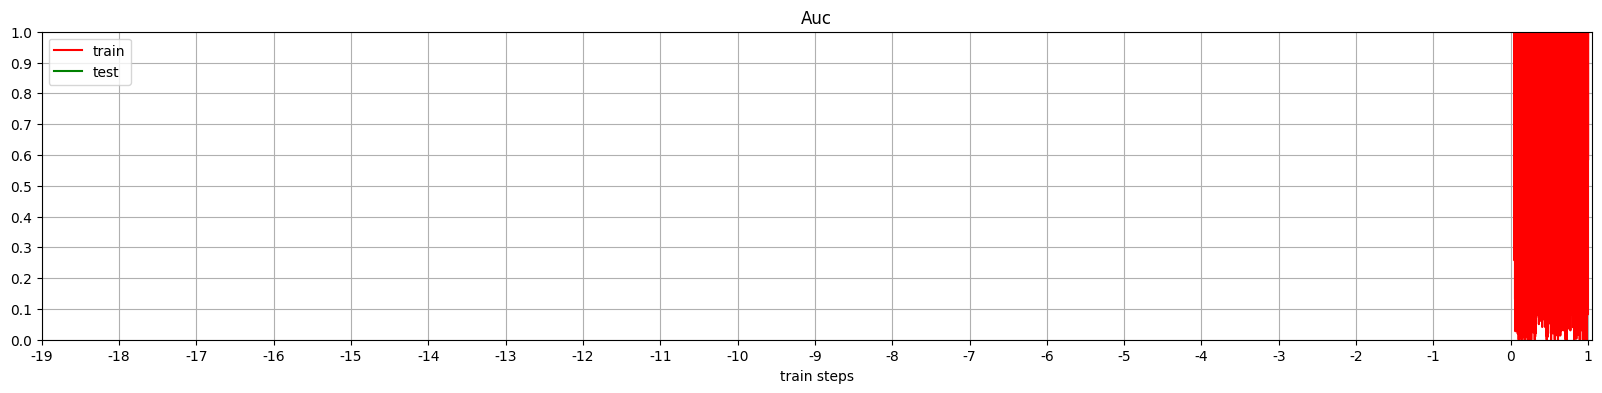

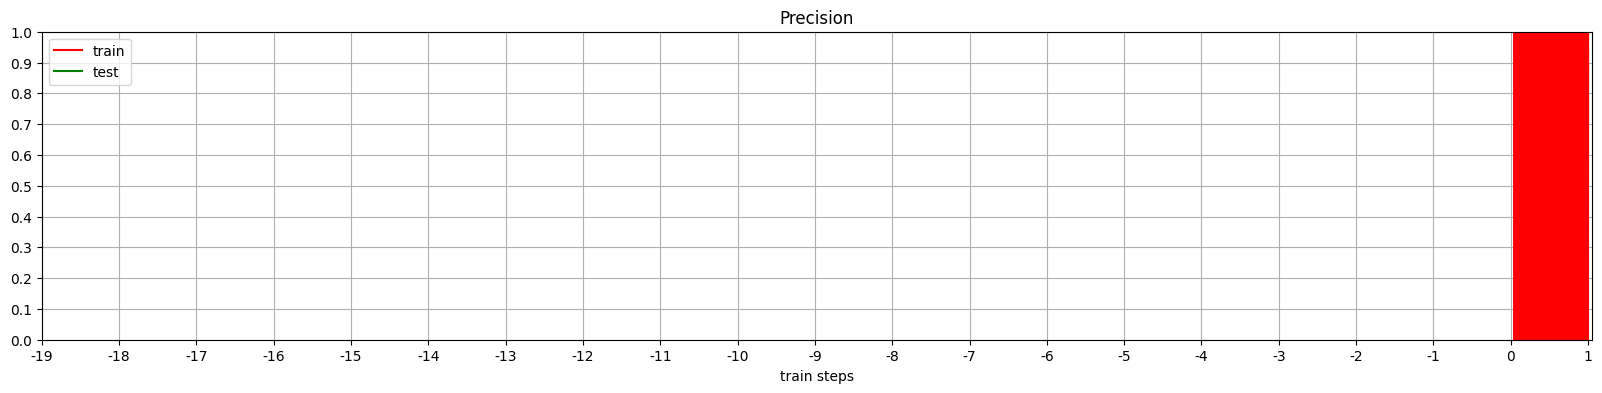

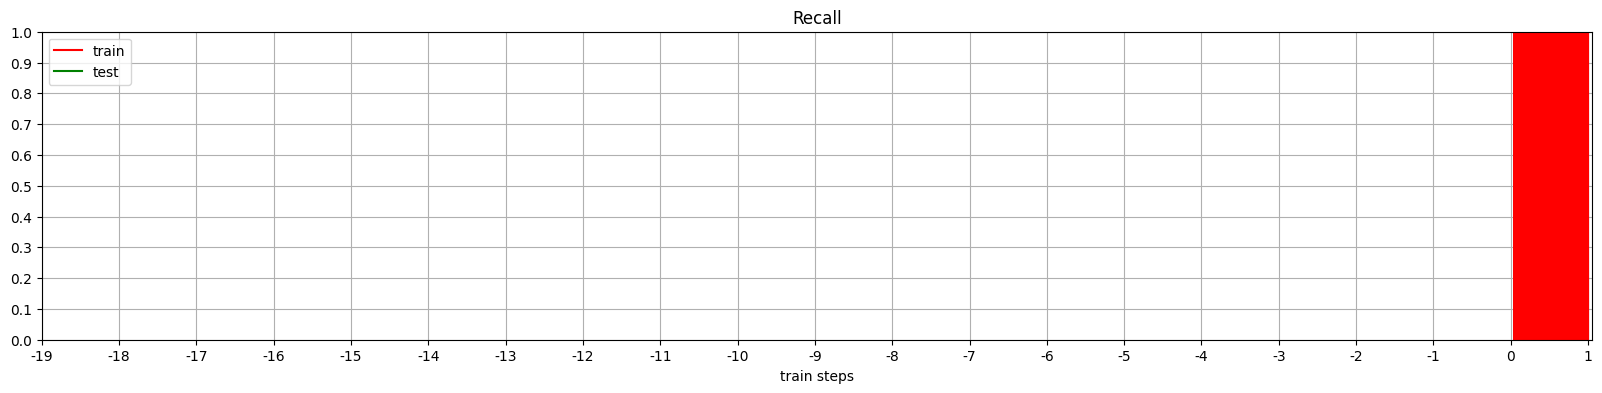

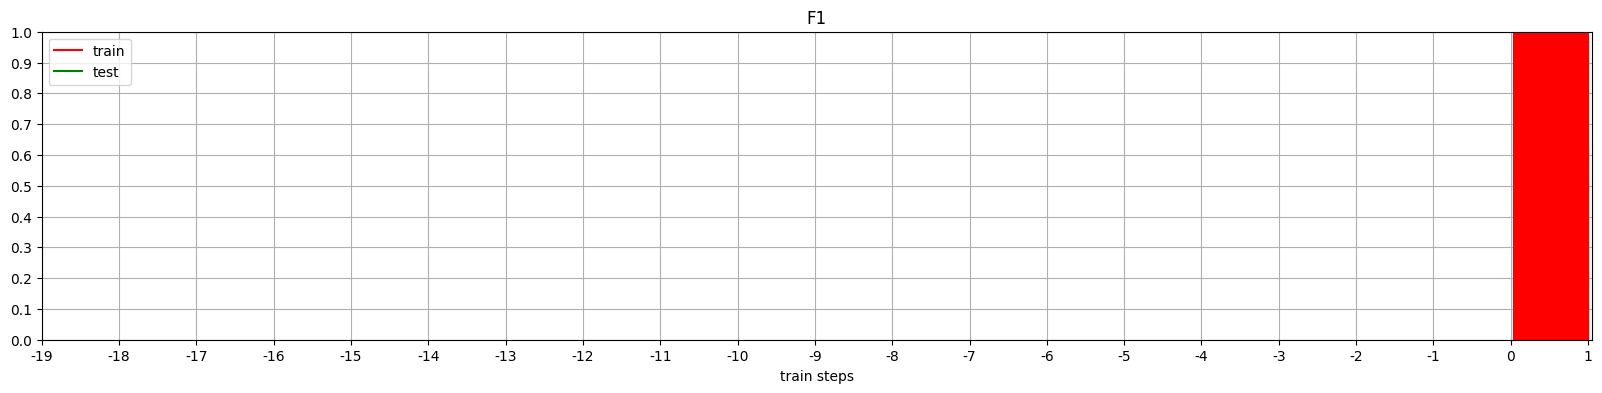

Time:  26.205955521265665
Epoch 1: ROC-AUC = 93.03%
Epoch 1: Precision = 0.731
Epoch 1: Recall = 0.778
Epoch 1: F1-score = 0.735
Final ROC-AUC = 93.03%
Final Precision = 0.731
Final Recall = 0.778
Final F1-score = 0.735


In [10]:
n_epochs = 1

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, n_epochs, loader_train, loader_test, width)

In [11]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 0
Max F1-score: 73.5080%
ROC-AUC: 93.0256%
Precision: 0.7313
Recall: 0.7776
Mean time for 1 epoch 26.21 minutes


## Interpretation Pipeline for GraphZSAGEConv Model: instruction

In [ ]:
'''
algorithm can be:

- IntegratedGradients = default
- GuidedBackprop
- Deconvolution
- InputXGradient

model is trained and interpretated model; in eval()

loader_test, loader_train is interpreted data

width is width of the interval

save_filename is name of saved file

need_return whether output of interpretation is needed; 0 or 1

'''

In [8]:
'''
# example

cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GraphZSAGEConv_v5_lin_GuidedBackprop','GuidedBackprop', need_return=0)
# or
mean_GB = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GraphZSAGEConv_v5_lin_GuidedBackprop', 'GuidedBackprop', need_return=1)
'''

"\n# example\n\ncnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GraphZSAGEConv_v5_lin_GuidedBackprop','GuidedBackprop', need_return=0)\n# or\nmean_GB = cnn_interpretation_pipeline(model, loader_test, loader_train, width, 'mean_GraphZSAGEConv_v5_lin_GuidedBackprop', 'GuidedBackprop', need_return=1)\n"

## Interpretation

In [15]:
model.eval()

GraphZSAGEConv_v5_lin(
  (conv1): SAGEConv(1950, 1800, aggr=mean)
  (conv2): SAGEConv(1800, 1650, aggr=mean)
  (conv3): SAGEConv(1650, 1500, aggr=mean)
  (conv4): SAGEConv(1500, 1350, aggr=mean)
  (conv5): SAGEConv(1350, 1200, aggr=mean)
  (conv6): SAGEConv(1200, 1050, aggr=mean)
  (conv7): SAGEConv(1050, 900, aggr=mean)
  (conv8): SAGEConv(900, 750, aggr=mean)
  (conv9): SAGEConv(750, 600, aggr=mean)
  (conv10): SAGEConv(600, 450, aggr=mean)
  (conv11): SAGEConv(450, 300, aggr=mean)
  (conv12): SAGEConv(300, 150, aggr=mean)
  (conv13): SAGEConv(150, 64, aggr=mean)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)

In [19]:
mean_GB = graph_interpretation_pipeline(model, loader_test, width, 'GuidedBackprop', 'mean_GuidedBackprop',  need_return=1)

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_GuidedBackprop.pt


In [20]:
mean_IG = graph_interpretation_pipeline(model, loader_test, width, 'IntegratedGradients', 'mean_IntegratedGradients', need_return=1)

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_IntegratedGradients.pt


In [21]:
mean_DEC = graph_interpretation_pipeline(model, loader_test, width, 'Deconvolution', 'mean_Deconvolution', need_return=1)

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_Deconvolution.pt


In [22]:
mean_IXG = graph_interpretation_pipeline(model, loader_test, width, 'InputXGradient', 'mean_InputXGradient', need_return=1)

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_InputXGradient.pt


In [23]:
mean_GNNExp = graph_interpretation_pipeline(model, loader_test, width, 'GNNExplainer', 'mean_GNNExplainer', need_return=1)

  0%|          | 0/9041 [00:00<?, ?it/s]

done interpretation
Averaged tensor shape: torch.Size([1950])
Averaged tensor: tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
Interpretation result is an averaged tensor. It is saved as:
mean_GNNExplainer.pt


## Ranking

In [24]:
# in our features data first 4 indices correspond to ACTG
# as we are interested in omics data, we will remove ACTG before feature ranking

mean_IG = mean_IG[4:]
mean_IXG = mean_IXG[4:]
mean_DEC = mean_DEC[4:]
mean_GB = mean_GB[4:]

In [25]:
features_weights = {'IG' : mean_IG, 'IXG' : mean_IXG, 'DEC' : mean_DEC, 'GB' : mean_GB}
features_weights = pd.DataFrame(features_weights)

In [26]:
features_weights.head()

,IG,IXG,DEC,GB
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [27]:
features_range = get_ranked_features(features_weights)

In [28]:
features_range.head()

,mean_deviation
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


## Load Extracted Features

In [29]:
features = [i[:-4] for i in os.listdir('z_dna/hg38_features/sparse/') if i.endswith('.pkl')]
feature_names = [i for i in features]

# the number of extracted features
top_count = 100
features_top = features_range.iloc[:top_count].index.tolist()

top = []
for index in features_top:
    top.append(features[index])


features = top
feature_names = [i for i in features]

In [30]:
DNA_features = {feature: load(f'z_dna/hg38_features/sparse/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
np.random.seed(10)

width = 100

train_dataset, test_dataset, edges = get_train_test_dataset_edges_graph(width, chroms, feature_names, DNA, DNA_features, ZDNA)

100%|█████████████████████████████████████████████████████████████████████████████| 165/165 [00:00<00:00, 67014.64it/s]


In [32]:
np.random.seed(42)
params = {'batch_size':32,
          'num_workers':4,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

## Train Model On New Features

In [33]:
set_random_seed(42)
torch.cuda.empty_cache()

with torch.cuda.device(device):
    model = GraphZSAGEConv_v5_lin(top_count=top_count, edge=edges)
    model = model.to(device)

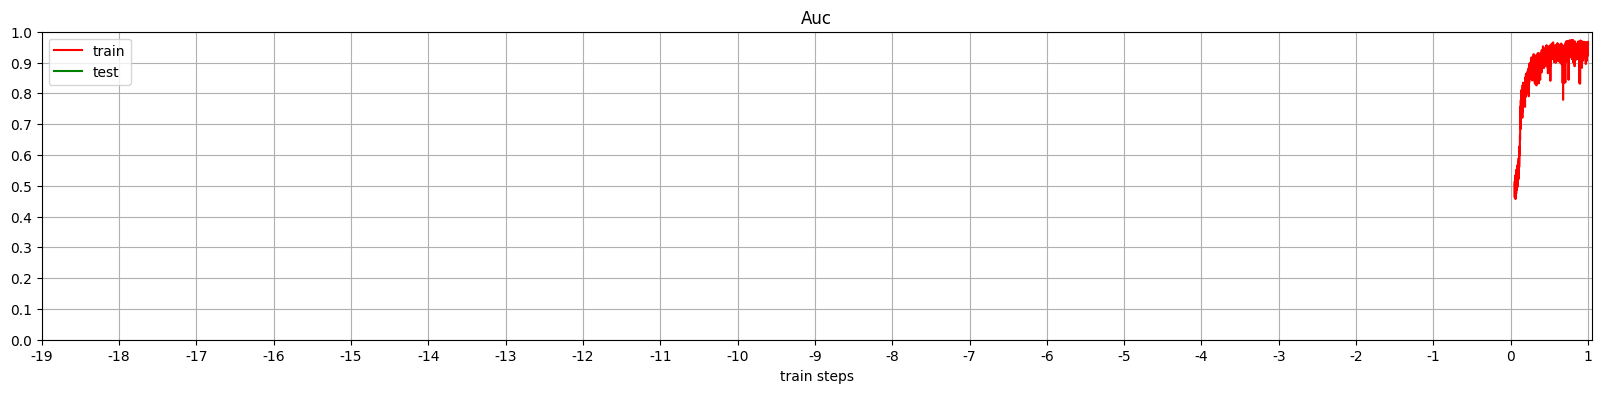

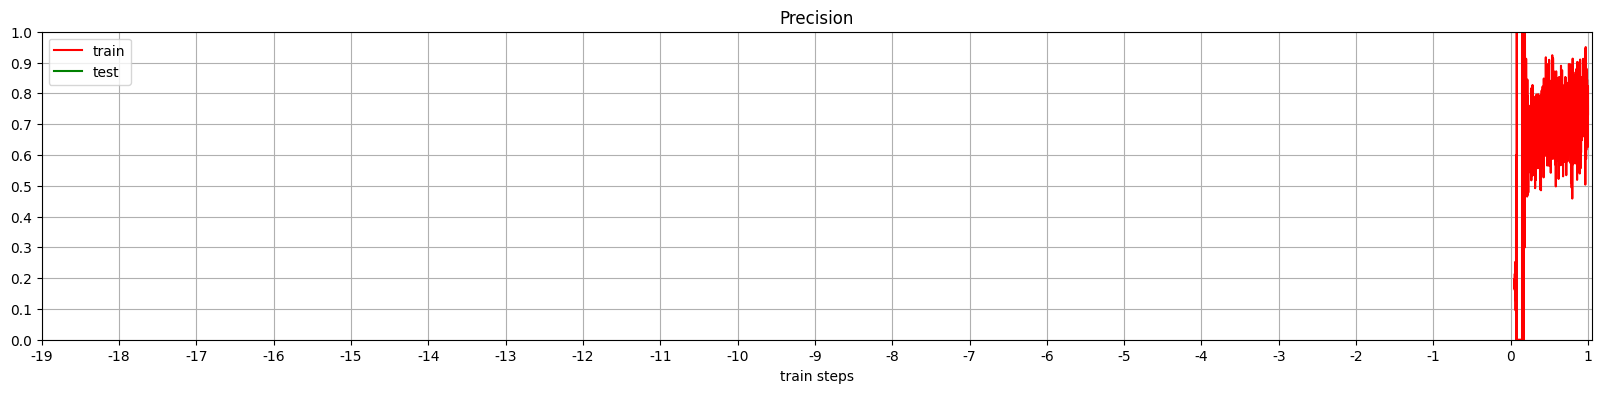

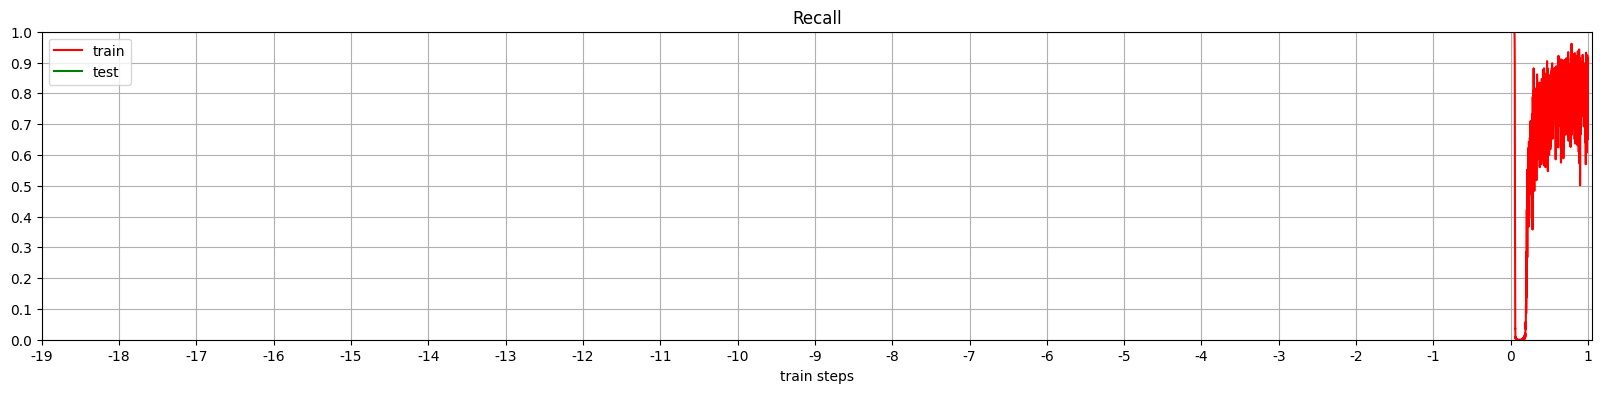

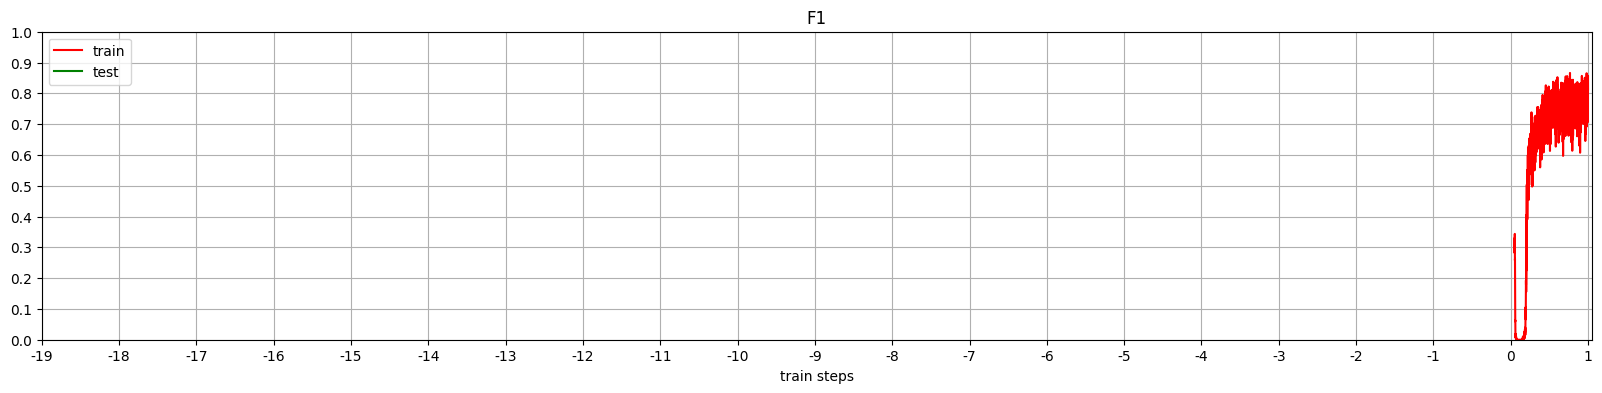

Time:  8.536702871322632
Epoch 1: ROC-AUC = 95.47%
Epoch 1: Precision = 0.752
Epoch 1: Recall = 0.852
Epoch 1: F1-score = 0.797
Final ROC-AUC = 95.47%
Final Precision = 0.752
Final Recall = 0.852
Final F1-score = 0.797


In [35]:
n_epochs = 1

opt = torch.optim.Adam(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times = train(model, opt, n_epochs, loader_train, loader_test, width)

In [36]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 0
Max F1-score: 79.7470%
ROC-AUC: 95.4652%
Precision: 0.7519
Recall: 0.8518
Mean time for 1 epoch 8.54 minutes
